# Membros da Equipe

__- Gabriel Telles Missailidis__

__- João Lucas Rocha Rolim__

__- Samir Nunes da Silva__

#### Obs: a seguir, há classes e funções definidas para a resolução do projeto. Os tópicos começam após esses códigos, com 1. Descrição dos dados escolhidos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC
from typing import Self
from logging import getLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.exceptions import NotFittedError
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
class Config:
    DATA_FOLDER = f"../data"
    ANALYSIS_FOLDER = f"../analysis"
    TRAIN_FILE = "train.csv"
    TEST_FILE = "test.csv"
    FEATURES_SUBSETS = {
        "mome": "Moments",
    }


class BaseWrapper(ABC):
    TARGET = "Class"
    
    def __init__(self, class_name):
        self.config = Config()
        self.logger = getLogger(class_name)

    def _map_features_subset(self, features_subset: str):
        if features_subset in self.config.FEATURES_SUBSETS.values():
            return features_subset
        if features_subset in self.config.FEATURES_SUBSETS.keys():
            return self.config.FEATURES_SUBSETS[features_subset]
        self.logger.exception(
            f"features_subset must be in {self.config.FEATURES_SUBSETS.values()} or {self.config.FEATURES_SUBSETS.keys()}"
        )
        raise ValueError


class DataLoader(BaseWrapper):
    """Wrapper for loading data"""

    def __init__(self):
        super().__init__(__name__)

    def load(self, features_subset: str):
        features_subset = self._map_features_subset(features_subset)
        return self._name_dataframes(
            *self._split_features_labels(
                *self._load_train_test(features_subset)
            ),
            features_subset
        )

    def _load_train_test(
        self, features_subset: str
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        folder = f"{self.config.DATA_FOLDER}/{features_subset}"
        return (
            pd.read_csv(
            f"{folder}/{self.config.TRAIN_FILE}", index_col=[0]
        ), 
            pd.read_csv(
            f"{folder}/{self.config.TEST_FILE}", index_col=[0]
        )
        )

    def _split_features_labels(
        self, train: pd.DataFrame, test: pd.DataFrame
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        X_train, y_train = (
            train.drop(self.TARGET, axis=1), train[self.TARGET]
        )
        X_test, y_test = (
            (test.drop(self.TARGET, axis=1), test[self.TARGET])
            if self.TARGET in test.columns
            else (test, None)
        )
        return X_train, X_test, y_train, y_test

    def _name_dataframes(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
        features_subset: str,
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        dfs = (X_train, X_test, y_train, y_test)
        for df in dfs:
            if df is not None:
                df.attrs["name"] = features_subset
        return dfs
    
class DataAnalyzer(BaseWrapper):
    def __init__(self, X_train, y_train):
        super().__init__(__name__)
        self._data = pd.concat([X_train, y_train], axis=1)
        self._data.attrs["name"] = X_train.attrs["name"]
      
    def __str__(self):
        return str(self._data)
    
    def analyze(self):
        self.data_info()
        self.data_summary()
        if len(self._data.drop(self.TARGET, axis=1).columns) <= 25:
            self.correlogram()
            self.features_histograms()
            self.target_feature_scatterplots()
        
    def data_info(self):
        print(self._data.info(verbose=True))
        
    def data_summary(self):
        print(self._data.describe())
      
    def correlogram(self):
        annot = len(self._data.drop(self.TARGET, axis=1).columns) <= 6
        sns.heatmap(self._data.corr("pearson"), cmap="inferno", annot=annot)
        plt.title(f"{self._data.attrs["name"]} Correlogram", fontsize=22)
        plt.show()
        
    def features_histograms(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].hist(self._data[feature])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel("Count", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Features Histograms", fontsize=22)
        plt.show()
        
    def target_feature_scatterplots(self):
        feature_cols = self._data.drop(self.TARGET, axis=1).columns
        size = int(np.ceil(np.sqrt(len(feature_cols))))
        fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(20,18))
        for i in range(size):
            for j in range(size):
                col_pos = i * size + j
                if col_pos >= len(feature_cols):
                    break
                feature = feature_cols[col_pos]
                axs[i, j].scatter(x=self._data[feature], y=self._data[self.TARGET])
                axs[i, j].set_xlabel(f"{feature} Value", fontsize=10)
                axs[i, j].set_ylabel(f"{self.TARGET}", fontsize=10)
        plt.suptitle(f"{self._data.attrs["name"]} Target-Feature Scatterplots", fontsize=22)
        plt.show()
        
class DataPipeline(BaseWrapper):
    
    CONTINUOUS_TYPES = set([np.float64])
    DISCRETE_TYPES = set([np.int64])
    
    def __init__(self):
        self._feature_selector = VarianceThreshold(threshold=0.0)
        self._imputer = make_column_transformer(
            (SimpleImputer(strategy="mean"),
             make_column_selector(dtype_include=self.CONTINUOUS_TYPES)),
            (SimpleImputer(strategy="most_frequent"),
             make_column_selector(dtype_include=self.DISCRETE_TYPES))
        )
        self._scaler = MinMaxScaler()
        self._fitted = False
    
    def fit(self, X_train: pd.DataFrame) -> Self:
        self._feature_selector.fit(X_train)
        X_train_selected = pd.DataFrame(self._feature_selector.transform(X_train), \
                            columns=self._feature_selector.get_feature_names_out(X_train.columns))
        self._imputer.fit(X_train_selected)
        self._scaler.fit(X_train_selected)
        self._fitted = True
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self._fitted:
            X = pd.DataFrame(self._feature_selector.transform(X), \
                            columns=self._feature_selector.get_feature_names_out(X.columns))
            X = pd.DataFrame(self._imputer.transform(X), columns=X.columns)
            X = pd.DataFrame(self._scaler.transform(X), columns=X.columns)
            return X
        raise NotFittedError
    
    def fit_transform(self, X_train: pd.DataFrame) -> pd.DataFrame:
        self.fit(X_train)
        return self.transform(X_train)
    
class KMeansEvaluation:
    METRICS = ["Silhueta", "ARI"]
    
    @staticmethod
    def elbow_method(X: pd.DataFrame, pipeline: DataPipeline, random_state=0):
        X_preprocessed = pipeline.fit_transform(X)
        wcss = {}
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=random_state).fit(X_preprocessed)
            wcss[k] = kmeans.inertia_
        plt.figure()
        plt.plot(list(wcss.keys()), list(wcss.values()), marker="o")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
        plt.show()
        
    @classmethod
    def scores(cls, X: pd.DataFrame, y: pd.DataFrame, pipeline: DataPipeline, random_state=0):
        X_preprocessed = pipeline.fit_transform(X)
        cols = cls.METRICS
        print("Running model:")
        model = KMeans(n_clusters=2, random_state=random_state)
        print(model)
        labels = model.fit_predict(X_preprocessed)
        internal = silhouette_score(X_preprocessed, labels)
        external = adjusted_rand_score(y, labels)
        scores = pd.DataFrame(data=np.array([[internal, external]]), index=["k-means (k=2)"], columns=cols)
        scores.index.name = "Métrica de integração"
        return scores
        
class HierarchicalClusteringEvaluation:    
    LINKAGES = ["single", "average", "complete"]
    METRICS = ["Silhueta", "ARI"]
    
    @classmethod
    def scores(cls, X: pd.DataFrame, y: pd.DataFrame, pipeline: DataPipeline):
        X_preprocessed = pipeline.fit_transform(X)
        cols = cls.METRICS
        scores = None
        models = cls._get_models()
        print("Running models:")
        for i in range(len(models)):
            model = models[i]
            print(model)
            labels = model.fit_predict(X_preprocessed)
            internal = silhouette_score(X_preprocessed, labels)
            external = adjusted_rand_score(y, labels)
            row = pd.DataFrame(data=np.array([[internal, external]]), index=[f"{cls.LINKAGES[i]}-linkage"], columns=cols)
            if scores is None:
                scores = row
            else:
                scores = pd.concat([scores, row], axis=0)
        scores.index.name = "Métrica de integração"
        return scores
            
    @classmethod
    def _get_models(cls):
        return [AgglomerativeClustering(n_clusters=2, 
                                        metric="euclidean", 
                                        linkage=linkage)
                for linkage in cls.LINKAGES]
    

#### Importando os dados

In [3]:
loader = DataLoader()
data = {}
subset = "mome"
X_train, _, y_train, _ = loader.load(subset)

# 1. Descrição dos dados escolhidos

O subconjunto de dados escolhido para análise foi o `Moments`. A justificativa é que esse é um conjunto suficientemente pequeno para permitir boas análises descritivas, é facilmente interpretável e também é interessante analisar para verificar se features simples como os momentos estatísticos são capazes de realizar um bom agrupamento em um problema mais complexo.

Segundo a referência do desafio no Kaggle, `Moments`:

__Calcula os momentos estatísticos básicos de uma imagem, como média, desvio padrão, assimetria (skewness) e curtose. Os descritores de momentos complexos fornecem um conjunto completo de invariantes sem qualquer cálculo considerável para alterações rotacionais. Isso é alcançado utilizando a fase de um componente de referência (C21, C32, etc.) para cancelar o efeito das variações do ângulo de rotação por meio de uma relação simples.__

A seguir, será mostrada uma breve análise descritiva dos dados escolhidos.

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 1 to 122
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V2      80 non-null     float64
 1   V3      80 non-null     float64
 2   V4      80 non-null     float64
 3   V5      80 non-null     float64
 4   Class   80 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 3.8 KB
None
               V2         V3         V4          V5     Class
count   80.000000  80.000000  80.000000   80.000000  80.00000
mean    80.303177  19.381849   5.460810   48.292944   0.32500
std     18.388209  12.707064   2.145295   36.380115   0.47133
min     57.748000   5.068510   0.466932    0.443753   0.00000
25%     65.403527   9.794905   4.066747   22.772620   0.00000
50%     77.039458  15.979428   5.409646   38.495927   0.00000
75%     92.321219  25.423502   7.082335   71.896368   1.00000
max    130.067565  55.491316  10.780591  209.128002   1.00000


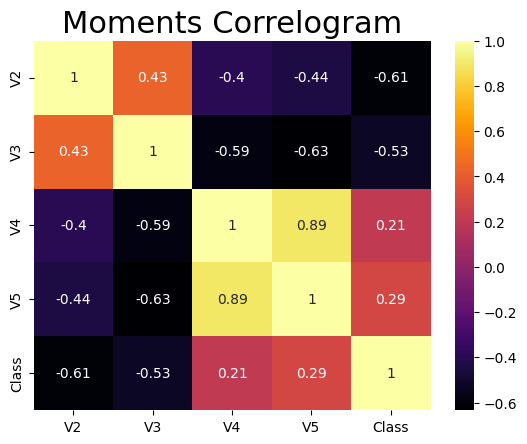

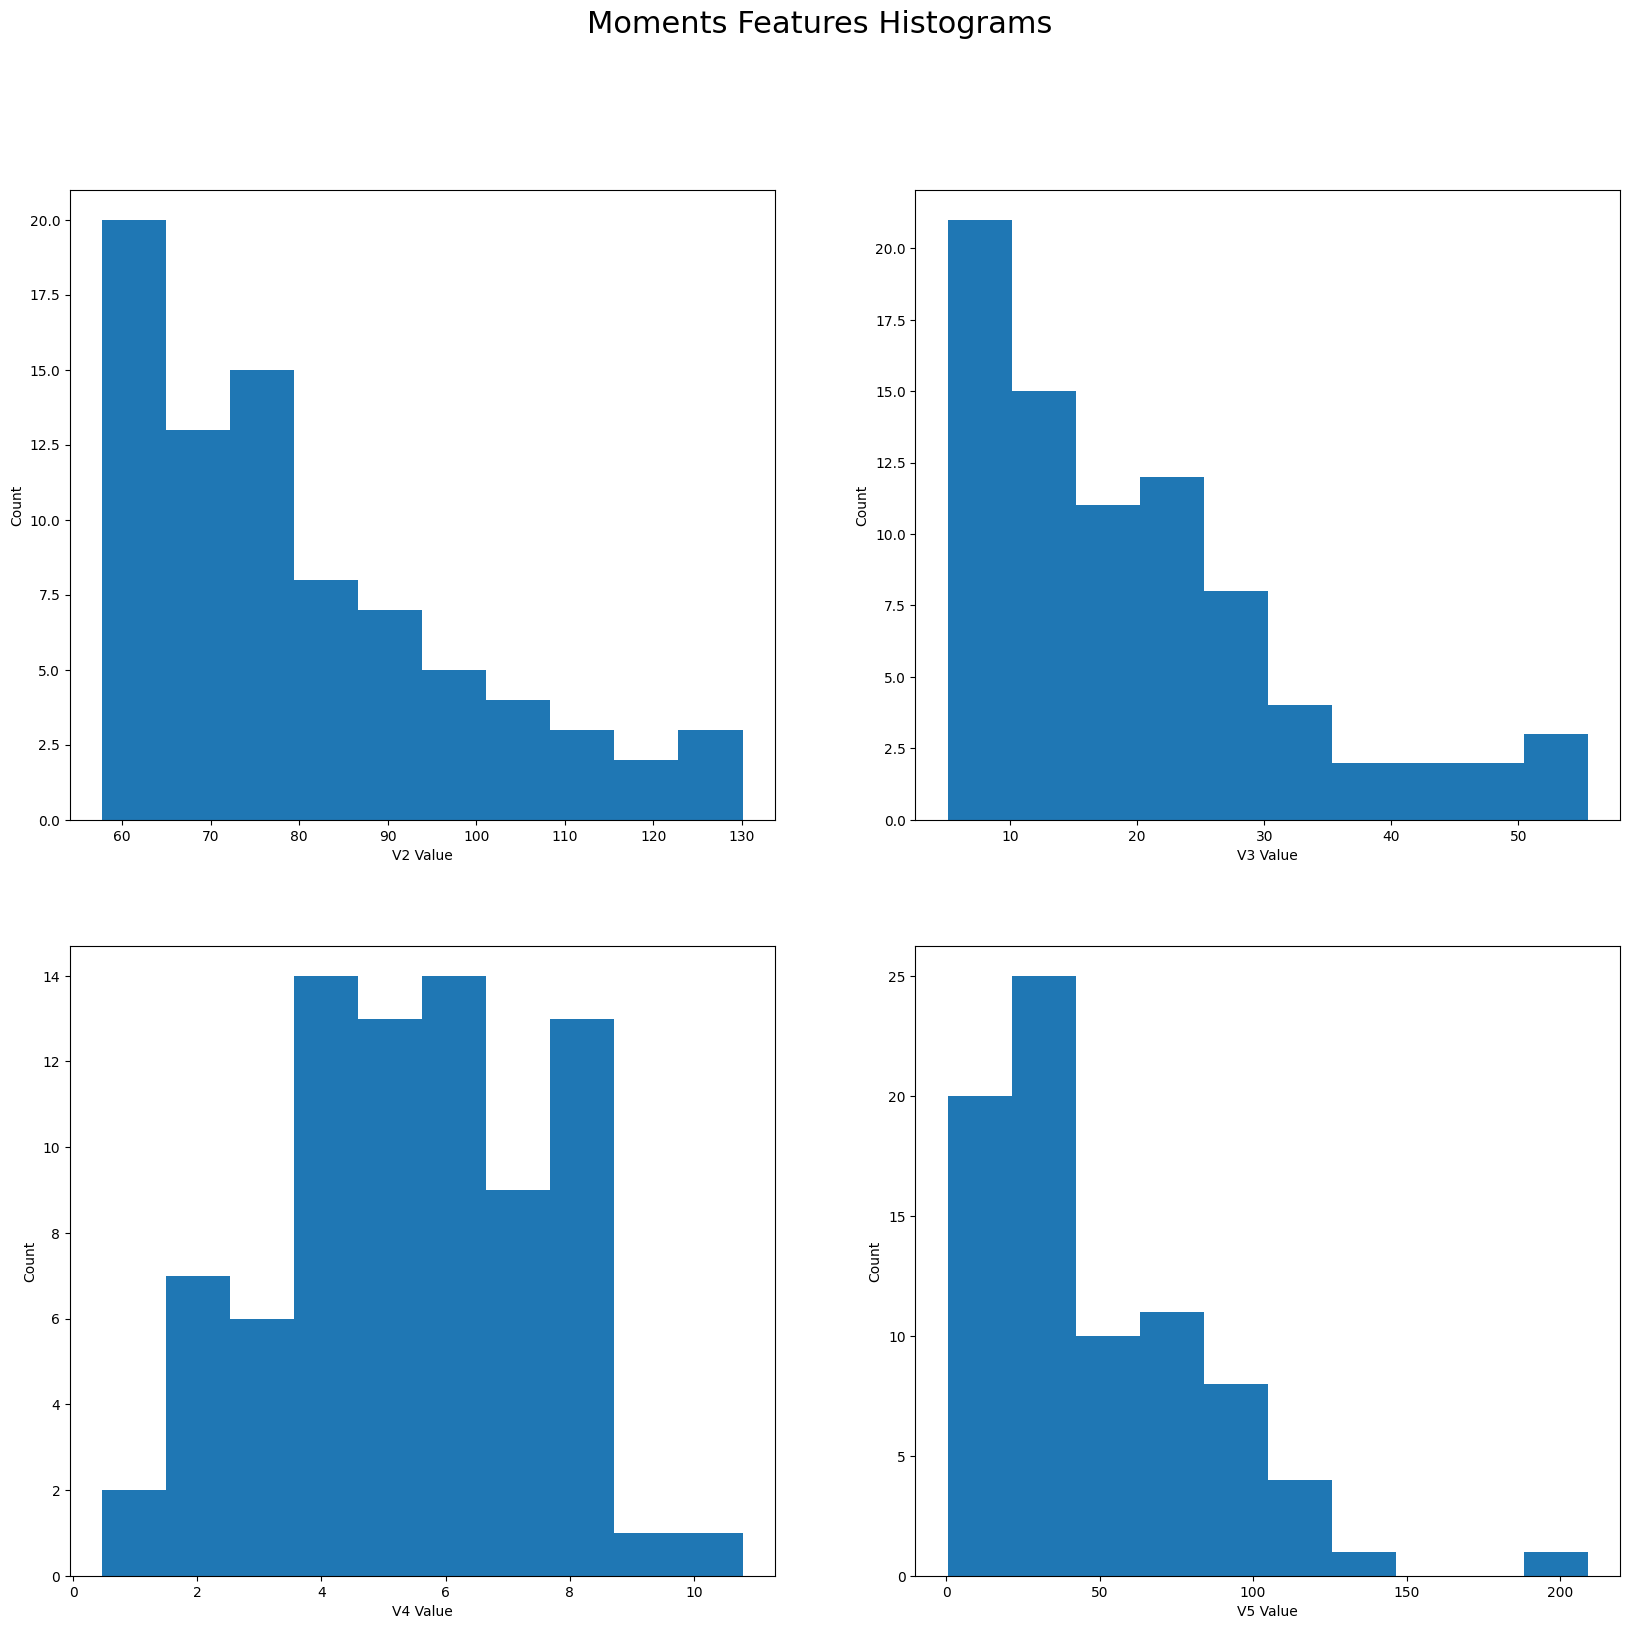

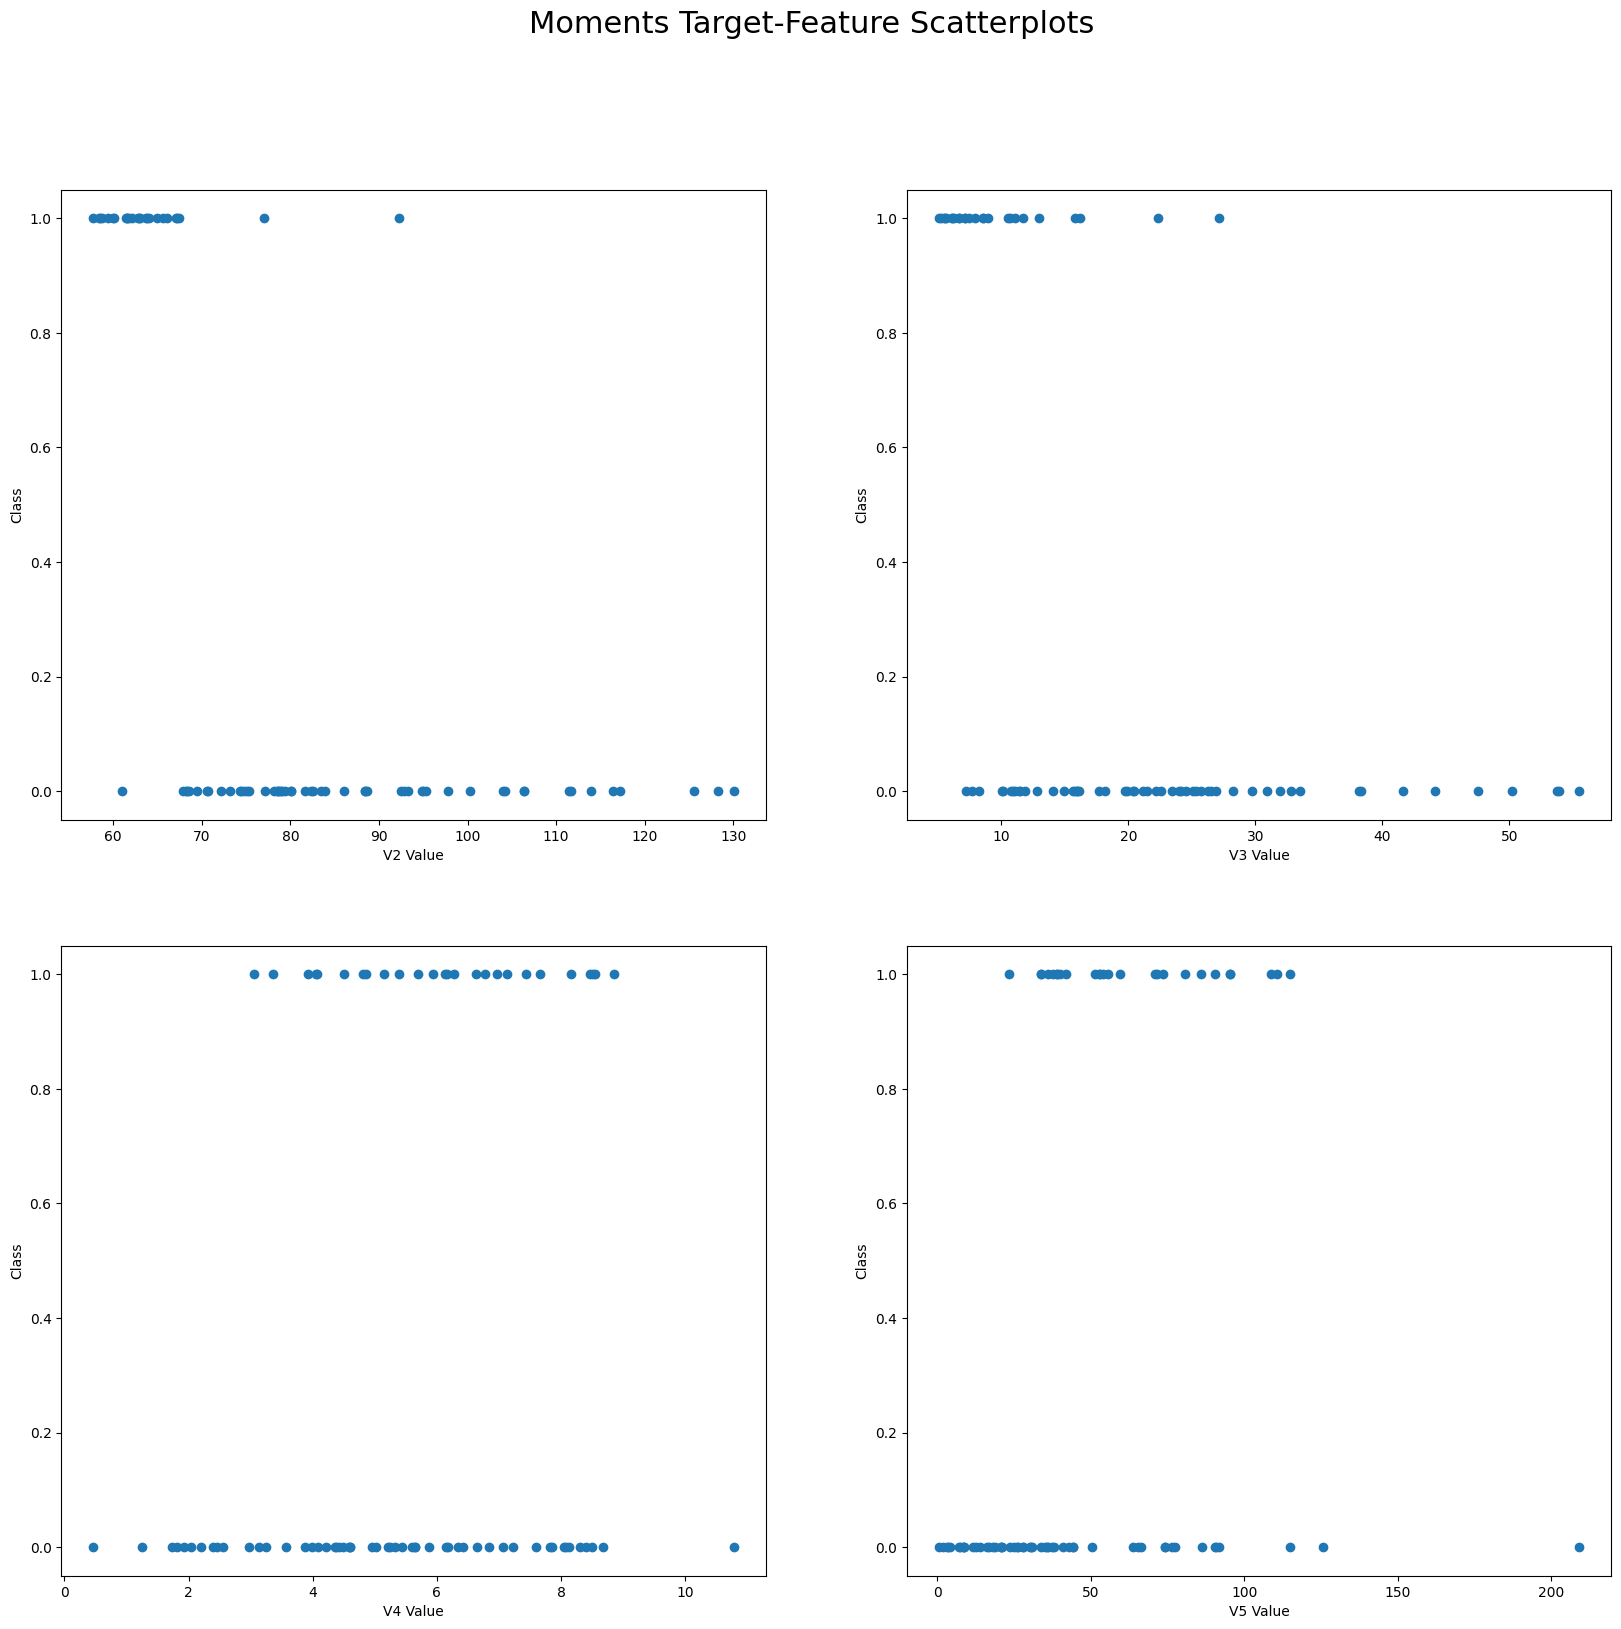

In [4]:
analyzer = DataAnalyzer(X_train, y_train)
analyzer.analyze()

Descrição:

- Conforme a primeira tabela, verifica-se que nenhuma das colunas de features (V2, V3, V4 e V5) nem a coluna do target (Class) possuem dados faltantes. Além disso, todas as features são do tipo float64 do Numpy, enquanto o target é do tipo int64 do Numpy. 

- Por sua vez, a segunda tabela mostra algumas estatísticas básicas de cada uma das colunas. Nota-se que as escalas de cada uma das colunas são consideravelmente diferentes, levando à necessidade de se utilizar um procedimento de scaling no pré-processamento, justamente pelo fato de ambos os algoritmos que usaremos (KMeans e AgglomerativeClustering) dependerem do cálculo de distâncias.

- Em seguida, o correlograma mostra as correlações de Pearson entre cada uma das variáveis. Entre vários pares, verifica-se correlações consideráveis, em módulo, o que pode afetar o resultado da clusterização ao enviesar as distâncias calculadas.

- Os histogramas apenas apresentação uma visualização gráfica da segunda tabela.

- Finalmente, os scatterplots mostram de maneira visual a relação entre cada feature e o target.

# 2. Resultados do k-médias com o método elbow

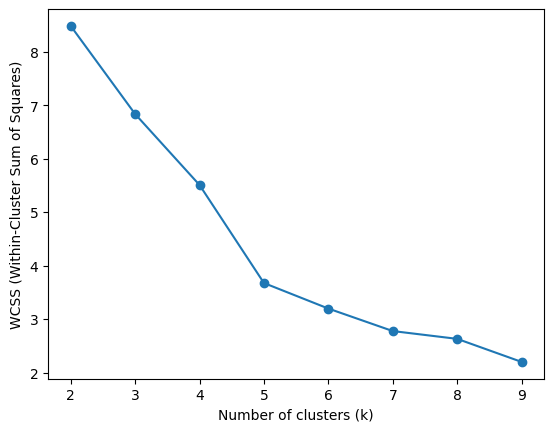

Running model:
KMeans(n_clusters=2, random_state=0)



,Silhueta,ARI
Métrica de integração,,
k-means (k=2),0.418101,0.103556


In [5]:
KMeansEvaluation.elbow_method(X_train, DataPipeline(), random_state=0)
kmeans_scores = KMeansEvaluation.scores(X_train, y_train, DataPipeline(), random_state=0)
print("")
kmeans_scores

# 3. Resultados de variações do algoritmo hierárquico e do k-médias

### 3.1. Resultados da clusterização hierárquica

In [6]:
hc_scores = HierarchicalClusteringEvaluation.scores(X_train, y_train, DataPipeline())
print("")
hc_scores

Running models:
AgglomerativeClustering(linkage='single')
AgglomerativeClustering(linkage='average')
AgglomerativeClustering(linkage='complete')



,Silhueta,ARI
Métrica de integração,,
single-linkage,0.432004,-0.012882
average-linkage,0.432004,-0.012882
complete-linkage,0.404715,0.125988


### 3.2. Todos os resultados

In [7]:
results = pd.concat([kmeans_scores, hc_scores], axis=0)
results

,Silhueta,ARI
Métrica de integração,,
k-means (k=2),0.418101,0.103556
single-linkage,0.432004,-0.012882
average-linkage,0.432004,-0.012882
complete-linkage,0.404715,0.125988


# 4. Discussões

### 2) Resultados do k-médias com o método elbow

- Conforme o método elbow, verifica-se que o número de clusters que deve ser escolhido é `k = 5`. O valor de `k` não bate com o número de classes original (duas classes). Isso pode ser explicado pelo fato de que apenas esse subconjunto de dados é incapaz de agrupar bem os dados nas classes originais, pois ele sozinho apresenta baixa capacidade explicativa do target. Além disso, os vieses associados à correlação entre as variáveis, que influenciam no cálculo das distâncias, também alteral a separabilidade dos grupos.

### 3) Resultados de variações do algoritmo hierárquico e do k-médias

#### 3.1) Resultados da clusterização hierárquica

- Nota-se que `single-linkage` e `average-linkage` apresentam os mesmos valores dos scores de silhueta e ARI. Por sua vez, `complete-linkage` apresentou um score de silhueta pior que os dois anteriores, mas um ARI score consideravelmente melhor. Isso indica que o uso de `complete-linkage` como métrica de integração favorece, nesse caso, uma melhor separação entre os clusters (maior coesão inter-clusters) em troca de uma maior separação dentro de cada cluster (menor coesão intra-clusters). Esse resultado faz sentido, já que `complete-linkage` usa a distância máxima entre todas as observações ao comparar dois conjuntos, enquanto `single-linkage` usa a distância mínima e `average-linkage` a distância média.

#### 3.2) Todos os resultados

- Nota-se que os resultados do `k-means` com k=2 se assemelham bastante aos resultados obtidos com a clusterização hierárquica utilizando `complete-linkage`. Em um aspecto geral, `k-means` performa melhor na compactação interna dos dois clusters obtidos, enquanto `complete-linkage` performa melhor em separar o par de clusters (isto é, os clusters são mais parecidos com a divisão de classes do target, representada por `y`). Tal resultado faz sentido, considerando as características específicas de cada abordagem: `k-means` itera para diminuir o WCSS (Within-Cluster Sum of Squares) enquanto a clusterização hierárquica com `complete-linkage` diferencia melhor os grupos de amostras por usar a distância máxima entre eles.

# 5. Conclusões: comentários e sugestões sobre o trabalho

### 5.1. Comentários

- O trabalho proposto foi bom para o aprendizado básico acerca de algoritmos de clusterização, em especial o `k-means` e a clusterização hierárquica com diferentes `linkages`. Muito legal poder comparar os algoritmos em uma mesma situação-problema, a qual é bastante interessante.

### 5.2. Sugestões

- Ao invés de pedir a entrega em jupyter notebook, seria melhor pedir um projeto com arquivos .py (um link do repositório no GitHub, por exemplo), pois isso melhora a modularização do trabalho e também permite aplicar boas práticas de engenharia de software, que muitas vezes não são possíveis no notebook. Por exemplo, o versionamento via git no jupyter notebook não existe da mesma forma que nos arquivos-fonte .py, e por isso não é utilizado em aplicações reais a serem colocadas em produção.

- Mostrar outras aplicações práticas desses algoritmos. Sugestão para a clusterização hierárquica baseada em correlações: agrupamento de fundos de investimento conforme as matrizes de correlação entre janelas de tempo das séries temporais dos retornos relativos de cada fundo. É possível inferir o número de grupos considerando os benchmarks (ex: IBOVESPA).